In [1]:
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools
from datetime import timedelta
from IPython.display import display

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

In [2]:
#leitura dos datasets
fraude_df = pd.read_csv("dados/Fraud_Data.csv")
ISP_df = pd.read_csv("dados/ipAddress_to_Country.csv") #dataset que verifica o pais do IP

### Tratamento de dados do primeiro dataset

In [3]:
display(fraude_df.head())
print(fraude_df.shape)
print('')
print(fraude_df.dtypes)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


(151112, 11)

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object


In [4]:
# convertendo as variáveis
fraude_df['cadastro'] = pd.to_datetime(fraude_df['cadastro'])
fraude_df['compra']   = pd.to_datetime(fraude_df['compra'])
fraude_df['ip'] = fraude_df['ip'].astype('float64')

fraude_df.dtypes

id                         int64
cadastro          datetime64[ns]
compra            datetime64[ns]
valor                      int64
id_dispositivo            object
fonte                     object
browser                   object
genero                    object
idade                      int64
ip                       float64
fraude                     int64
dtype: object

In [5]:
# detectando valores nulos
fraude_df.isnull().sum().sum()

0

In [6]:
# detectando valores NaN
fraude_df.isna().sum().sum()

0

### Tratamento de dados do segundo dataset

In [7]:
display(ISP_df.head())
print(ISP_df.shape)
print('')
print(ISP_df.dtypes)

,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


(138846, 3)

limite_inferior_ip    float64
limite_superior_ip      int64
pais                   object
dtype: object


In [8]:
#vamos conferir se todos os numeros que estao no dataset ISP_df são inteiros ou são decimais
ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print('Número de limites inferiores de endereço IP com decimal não-zero: {}'.format(ip_floats))

Número de limites inferiores de endereço IP com decimal não-zero: 0


In [9]:
# convertendo o limite inferior para inteiro
ISP_df.limite_inferior_ip = ISP_df.limite_inferior_ip.astype('int64')
ISP_df.dtypes

limite_inferior_ip     int64
limite_superior_ip     int64
pais                  object
dtype: object

In [10]:
# detectando valores nulos
ISP_df.isnull().sum().sum()

0

In [11]:
# detectando valores NaN
ISP_df.isna().sum().sum()

0

# Estatísticas descritivas

In [12]:
#estatisticas descritivas
display(fraude_df.describe())

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [13]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


array([[<AxesSubplot:title={'center':'ip'}>]], dtype=object)

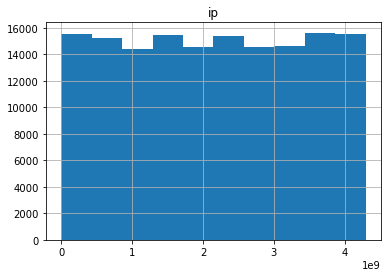

In [14]:
fraude_df.hist(['ip'])

array([[<AxesSubplot:title={'center':'limite_inferior_ip'}>]],
      dtype=object)

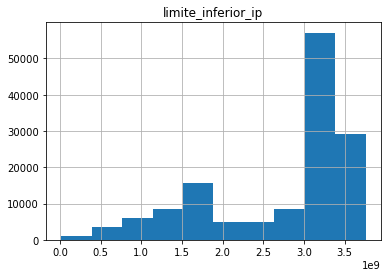

In [15]:
ISP_df.hist(['limite_inferior_ip'])

array([[<AxesSubplot:title={'center':'limite_superior_ip'}>]],
      dtype=object)

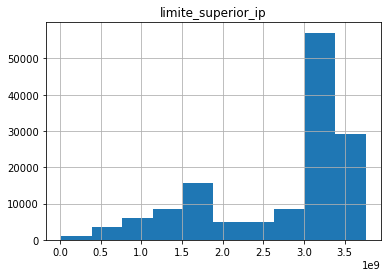

In [16]:
ISP_df.hist(['limite_superior_ip'])

> Ao analisar esses datasets vemos que o limite inferior do Ip não coincide entre eles. Isso acontece pois temos IPS no dataset de fraude que não está previsto no dataset de IPS. 

### Conferindo outliers no dataset de IPs

In [17]:
#checando os nossos outliers
display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max()])
display(ISP_df[ISP_df.limite_superior_ip == ISP_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


### Inserindo no dataset fraude_df o pais do IP

In [18]:
#funcao que mapeia se um IP do dataset ISP_df está presente no dataset de fraude e se ele aparece mais de uma vez
def isp_counts(isp):
    
    # verificando se o id do pais esta dentro do limite  lim_inf < ID < lim_sup
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)]['pais']

    if pais.shape[0] == 1:
        return print("Único")
    
    elif pais.shape[0] > 1:
        return print("Vários países") #mais de um país possui esse IP

    elif pais.shape[0] == 0:
        if isp > ISP_df.limite_superior_ip.max(): 
            return print("Muito grande") #pode ser uma fraude com o número de IP falso

        elif isp < ISP_df.limite_inferior_ip.min():
            return print("Muito pequeno") #pode ser uma fraude com o número de IP falso

        else:
            return print("Faltando")


#chamando a função para analisar os IPs do dataset de fraude
ip_counts = fraude_df['ip'].apply(isp_counts) #aqui o .ip indica a variavel que eu quero analisar
ip_counts.value_counts().value_counts().sum()

Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Muito pequeno
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Úni

Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único


Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Úni

Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Muito grande
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande


Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Úni

Muito pequeno
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único


Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Ún

Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único


Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único


Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Ún

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único


Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Faltando
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito 

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Muito grande
Faltando
Faltando
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Ún

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande


Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito pequeno
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Muito grande
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Faltando
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito

Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Ún

Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito 

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único

Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Ún

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito 

Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grand

Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Muito grande
Único
Único
Ú

Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Ún

Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Faltando
Único
Único
Único

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Fal

Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito 

Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Mu

Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltand

Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito pequeno
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Faltando
Únic

Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito gra

Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Únic

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Faltando
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Úni

Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ún

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito pequeno
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito gran

Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Faltando
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único


Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito g

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Ú

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único

Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito pequeno
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Mu

Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Ún

Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Ún

Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Úni

Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muit

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito gra

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Falt

Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito gra

Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Únic

Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único


Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único


Único
Muito grande
Faltando
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Muito 

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Únic

Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito pequeno
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Mui

Faltando
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito pequeno
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito gr

Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Ú

Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Muito grand

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Muito grande
Único
Ú

Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Muito grande
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito pequeno
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Ún

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Faltando
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único

Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito gran

Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Ún

Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Faltando
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único

Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito pequeno
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito gr

Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Ún

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito pequeno
Muito grande
Único
Único
Muito g

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito gr

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ún

Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Mu

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único


Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Ún

Muito grande
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Únic

Muito grande
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Faltando
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Faltan

Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Únic

Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito g

Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Muito grande
Único
Muito 

Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito pequeno
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito pequeno
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Faltando
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Muito grande
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Ú

Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Único
Ún

Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Faltan

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Faltando
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito pequeno
Muito grande
Único
Único
Muito grande
Único
Muito grande
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Únic

Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Ú

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
M

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Faltando
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Ún

Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único

Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Faltando
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único


Único
Único
Muito grande
Muito pequeno
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Faltando
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Úni

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Muito grande
Muito grande
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Muito grande
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

0

In [19]:
ISP_df.dtypes

limite_inferior_ip     int64
limite_superior_ip     int64
pais                  object
dtype: object

In [20]:
fraude_df.dtypes

id                         int64
cadastro          datetime64[ns]
compra            datetime64[ns]
valor                      int64
id_dispositivo            object
fonte                     object
browser                   object
genero                    object
idade                      int64
ip                       float64
fraude                     int64
dtype: object

In [21]:
# funcao para inserir o pais no dataset fraude_df
def ip_para_pais(ip):
    temp = ISP_df[(ISP_df.limite_inferior_ip <= ip) & (ISP_df.limite_superior_ip >= ip)].pais
    
    if temp.shape[0] == 1:
        return temp.iloc[0] #retorna a primeira linha do data-set :)
    
    elif temp.shape[0] < 1:
        return # print("Faltando")
    
    elif temp.shape[0] > 1:
        return # print("Erro")

In [22]:
#inserindo os paises no dataset de fraude, ou caso não encontre o valor será None
fraude_df["pais"] = fraude_df['ip'].apply(ip_para_pais)

In [23]:
fraude_df.head(3)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


### Removendo valores NAN que são outliers

In [24]:
# verificando se temos valores duplicados
fraude_df.drop_duplicates(subset=['pais'])
fraude_df.shape

(151112, 12)

In [25]:
# verificando valores NAN
fraude_df['pais'].isna().sum().sum()

21966

In [26]:
# removendo os valores NAN
fraude_df = fraude_df.dropna()
fraude_df.reset_index(drop=True)
display(fraude_df.head())
fraude_df['pais'].isna().sum().sum()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


0

In [27]:
 # salvando o dataset 
fraude_df.to_csv("dados/Dados_fraude_com_pais_modificado.csv", index= False)

# **Análise Exploratória de Dados**

In [28]:
# abrindo o dataset 
fraude_df = pd.read_csv("dados/Dados_fraude_com_pais_modificado.csv", header=0)
fraude_df.head(3)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x432 with 0 Axes>

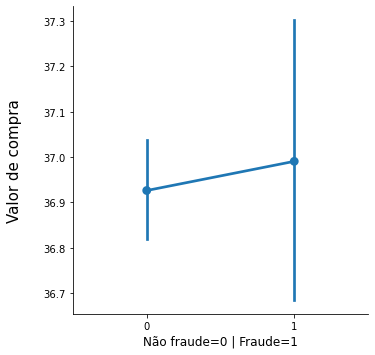

In [29]:
#grafico que mostra as barras de erro e o valor médio de duas variáveis
plt.figure(figsize=(10,6))
sns.factorplot(x="fraude", y="valor", data = fraude_df)
plt.xlabel("Não fraude=0 | Fraude=1", fontsize=12)
plt.ylabel("Valor de compra\n", fontsize=15)
plt.show()

> Ao plotar o gráfico não conseguimos tantas informações pois notamos que as médias de compras com fraude são bem próximas as médias de não fraude. Além disso também temos as barras de erro variando bastante para ambos os casos.

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x432 with 0 Axes>

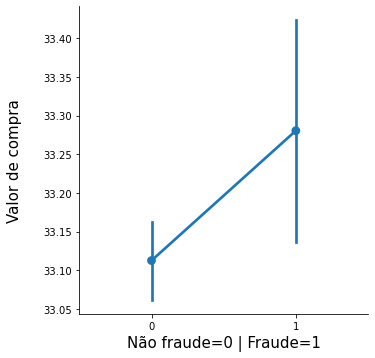

In [30]:
#grafico que mostra as barras de erro e o valor médio de duas variáveis
plt.figure(figsize=(10,6))
sns.factorplot(x="fraude", y="idade", data = fraude_df)
plt.xlabel("Não fraude=0 | Fraude=1", fontsize=15)
plt.ylabel("Valor de compra\n", fontsize=15)
plt.show()

> Ao observar o grafico vemos que há uma disparidade entre as médias, mas é um aumento sutil pois a media vai de 33,15 para 33,30. Portanto não podemos afirmar que temos uma correlação entre a  fraude e a idade.

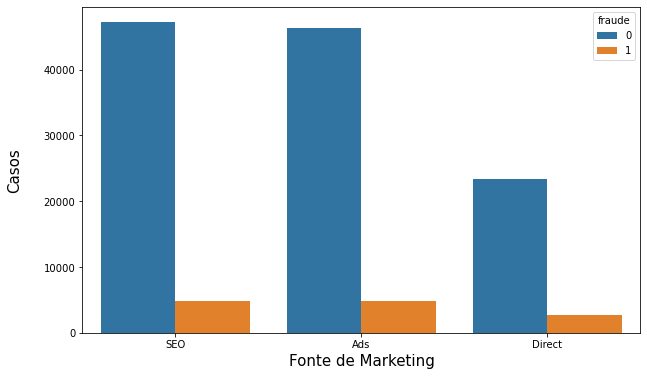

In [31]:
#plotando um gráfico para analisar casos de fraude entre fontes de marketing
#legenda 0 = sem fraude , 1 = com fraude
plt.figure(figsize=(10,6))
sns.countplot(x="fonte", hue="fraude", data=fraude_df)
plt.xlabel("Fonte de Marketing", fontsize=15)
plt.ylabel("Casos\n", fontsize=15)
plt.show()

> Aqui notamos que não podemos inferir que a fonte de trafego de origem do usuário influencia em caso uma possibildiade maior de fraude

In [32]:
#criando dois datasets contedo os casos de não fraude e de fraude
soma_fraude = fraude_df[fraude_df["fraude"] >= 1]["fraude"].groupby(fraude_df.pais).sum()
soma_fraude = pd.DataFrame(soma_fraude).reset_index()

soma_nao_fraude = fraude_df[fraude_df["fraude"] == 0]["fraude"].groupby(fraude_df.pais).sum()
soma_nao_fraude = pd.DataFrame(soma_nao_fraude).reset_index()

# verificando os dataframes
display(soma_fraude)
display(soma_nao_fraude)

,pais,fraude
0,Afghanistan,1
1,Algeria,13
2,Angola,1
3,Argentina,66
4,Armenia,2
...,...,...
104,Uruguay,5
105,Uzbekistan,2
106,Venezuela,33
107,Viet Nam,37


,pais,fraude
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Angola,0
4,Antigua and Barbuda,0
...,...,...
175,Viet Nam,0
176,Virgin Islands (U.S.),0
177,Yemen,0
178,Zambia,0


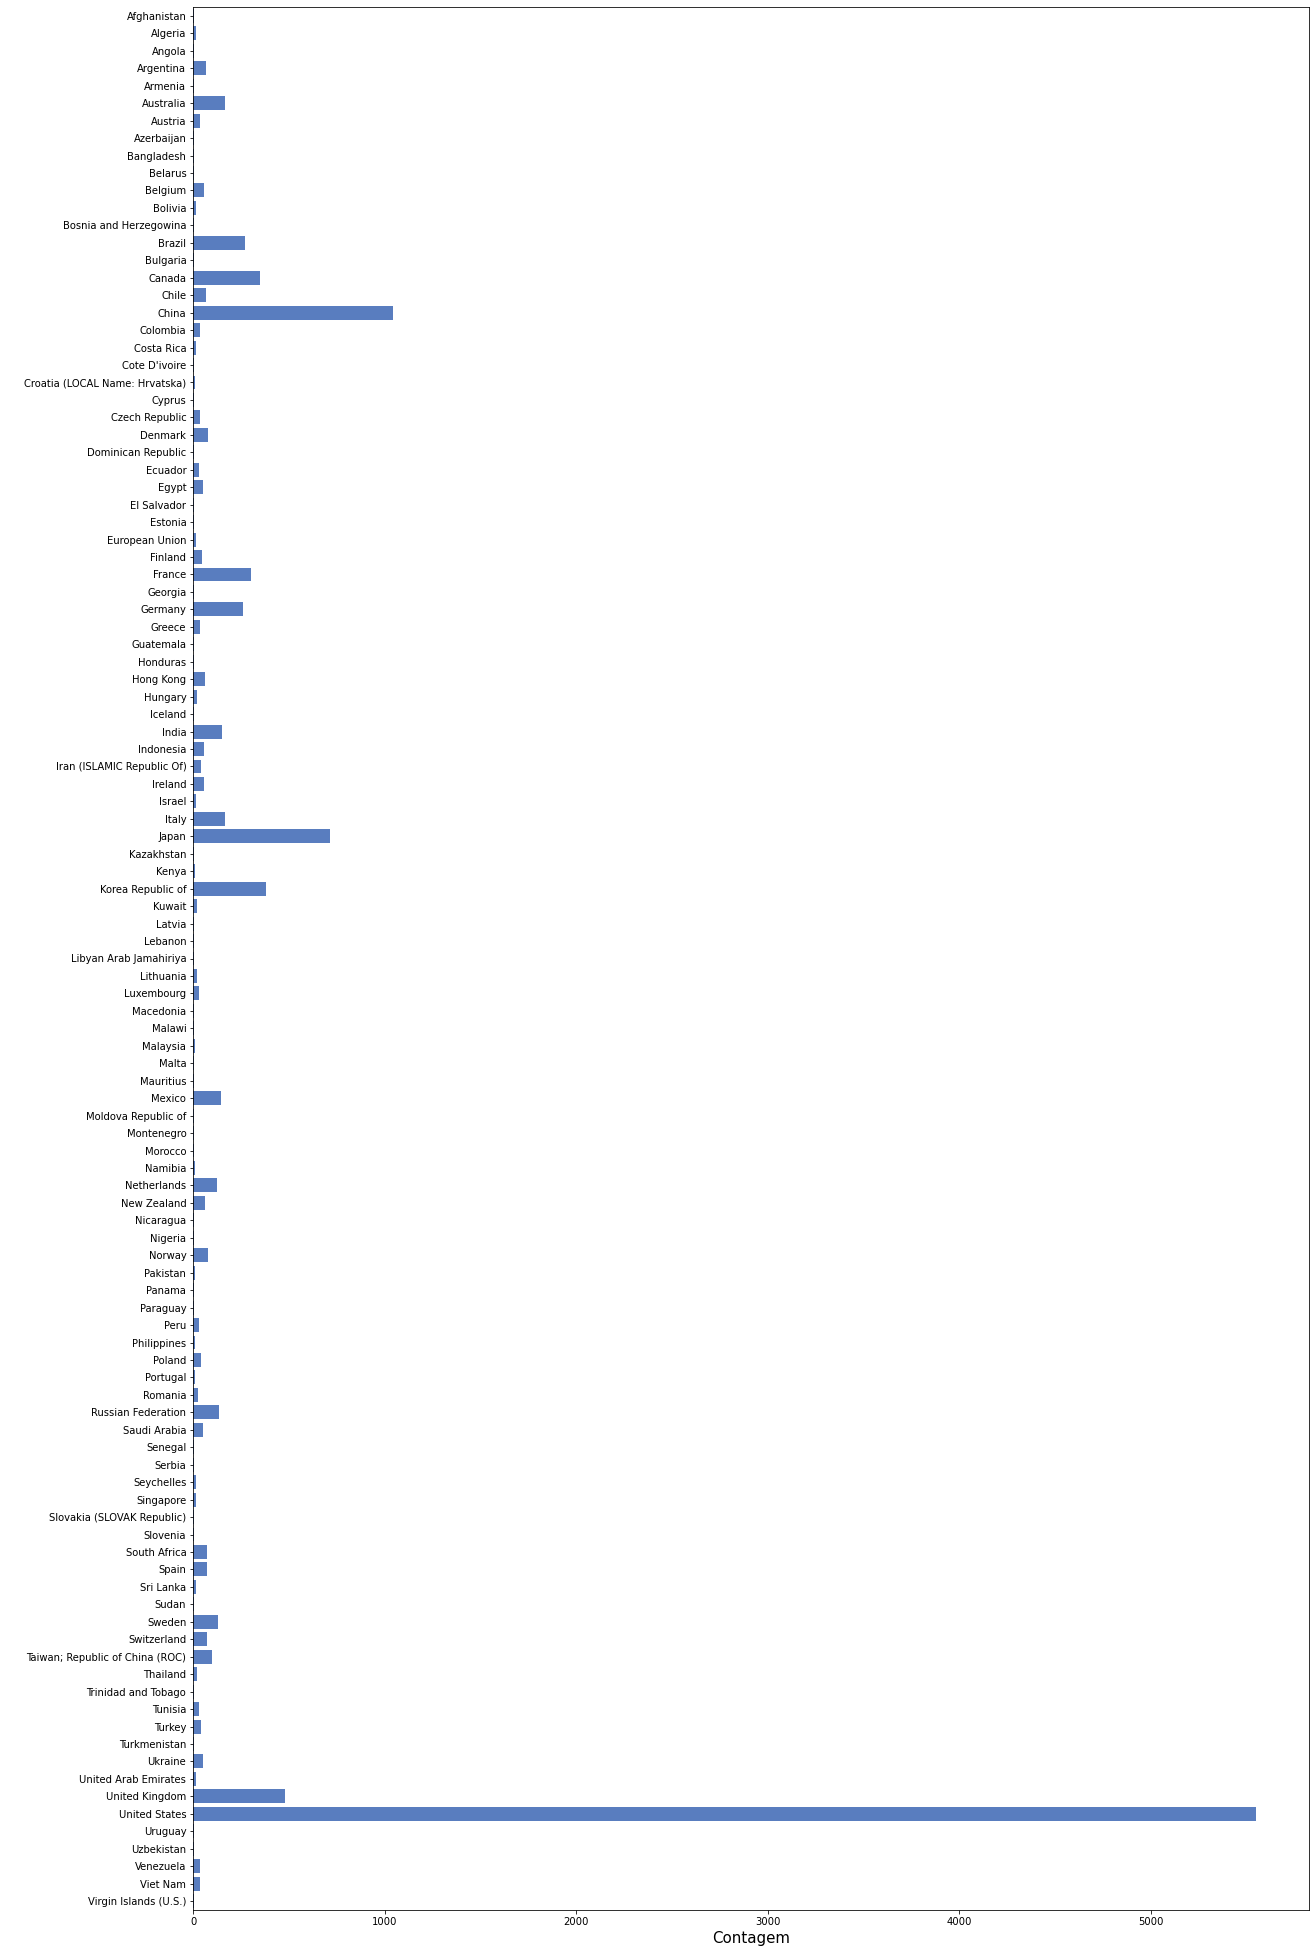

In [33]:
#grafico que analisa os pais que contem mais fraude
plt.figure(figsize=(20,35))
sns.set_color_codes("muted")
sns.barplot(x="fraude",y="pais", data=soma_fraude, label="Total", color="b")
plt.xlabel("Contagem", fontsize=15)
plt.ylabel(" ", fontsize=12)
plt.show()

> Aqui notamos que os Estados Unidos podem conter as maiores fraudes

In [34]:
fraude_df.head(3)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


In [35]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
pais               object
dtype: object

In [36]:
# explorando a relacao entre o IP e o disposito para casos de fraude

# verificando se um mesmo dispositivo tem mais de um IP
tmp_df = pd.DataFrame(columns=("fraude", "id_por_dispositivo", "id_por_ip"))

#inserindo as colunas no dataset
tmp_df["fraude"] = fraude_df["fraude"]

userid_count = fraude_df.groupby("id_dispositivo").id.count()
tmp_df["id_por_dispositivo"] = fraude_df.id_dispositivo.apply(lambda x: userid_count[x])

In [37]:
userid_count2 = fraude_df.groupby("ip").id.count()
tmp_df["id_por_ip"] = fraude_df['ip'].apply(lambda x: userid_count2[x])

In [38]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip
0,0,1,1
1,0,1,1
2,1,12,12
3,0,1,1
4,0,1,1


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x360 with 0 Axes>

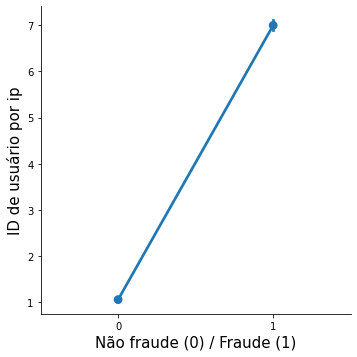

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x360 with 0 Axes>

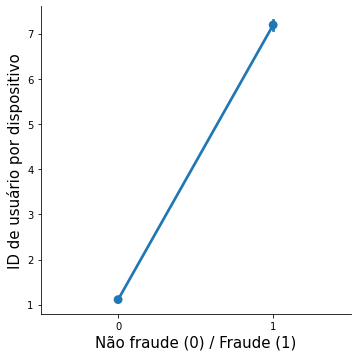

In [39]:
#plotando os graficos
plt.figure(figsize=(10,5))
sns.factorplot(x="fraude",y="id_por_ip", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por ip", fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.factorplot(x="fraude",y="id_por_dispositivo", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por dispositivo", fontsize=15)
plt.show()

> Aqui notamos que os casos de fraude envolvem o uso de mais de um dispositivo por usuário, bem como o uso de vários IPS na mesma máquina

In [40]:
#criando novas variaveis
tmp_df["cadastro"] = fraude_df['cadastro'].apply(pd.to_datetime)
tmp_df["compra"] = fraude_df.compra.apply(pd.to_datetime)

tmp_df["tempo"] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461
4,0,1,1,2015-05-21 06:03:03,2015-07-09 08:05:14,7331


In [41]:
tmp_df["media_id"] = (tmp_df.id_por_dispositivo + tmp_df.id_por_ip) * 0.5

In [42]:
userid_count_id = fraude_df.groupby("id_dispositivo").id.count()
fraude_df["id_por_dispositivo"] = fraude_df.id_dispositivo.apply(lambda x: userid_count_id[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,1


In [43]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo,media_id
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,1.0
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944,1.0
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1,12.0
3,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461,1.0
4,0,1,1,2015-05-21 06:03:03,2015-07-09 08:05:14,7331,1.0


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x360 with 0 Axes>

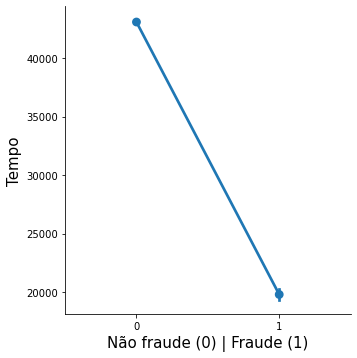

In [44]:
#plotando os graficos
plt.figure(figsize=(10,5))
sns.factorplot(x="fraude",y="tempo", data=tmp_df)
plt.xlabel("Não fraude (0) | Fraude (1)", fontsize=15)
plt.ylabel("Tempo", fontsize=15)
plt.show()


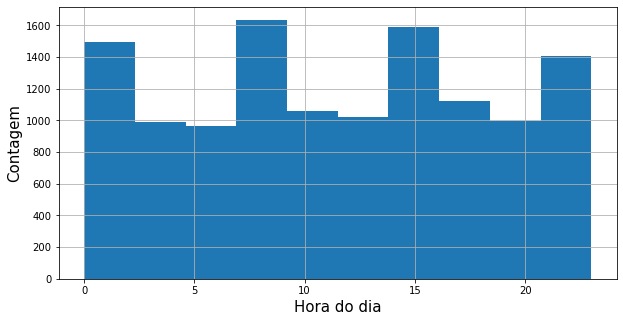

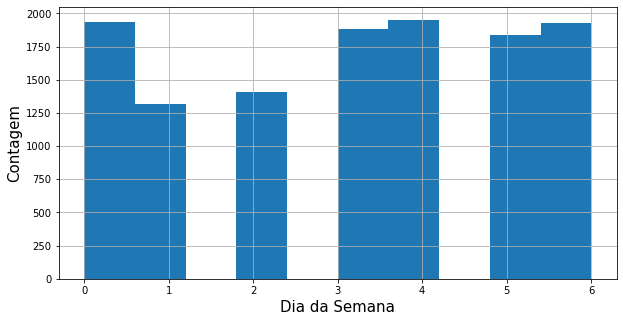

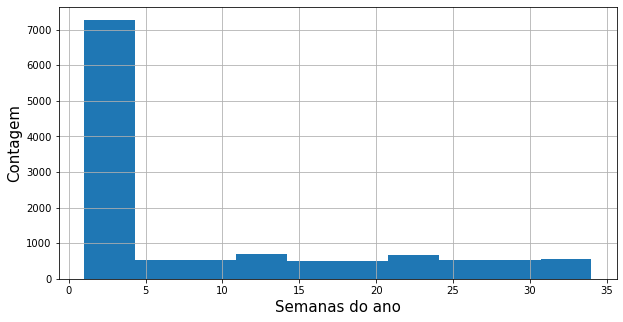

In [45]:
#analisando os dias, semanas e horas em que ocorrem mais fraudes através dos filtros

#grafico de horas
plt.figure(figsize=(10,5))
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Hora do dia", fontsize=15)
plt.ylabel("Contagem", fontsize=15)
plt.show()

#grafico de dias
plt.figure(figsize=(10,5))
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Dia da Semana", fontsize=15)
plt.ylabel("Contagem", fontsize=15)
plt.show()

#grafico de semanas
plt.figure(figsize=(10,5))
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Semanas do ano", fontsize=15)
plt.ylabel("Contagem", fontsize=15)
plt.show()


> Aqui notamos que no início do ano os números de fraude são maior. Porém nada podemos inferir dos dias da semana, visto que os valores são muito próximos, bem como também nada podemos inferir da hora do dia.

In [51]:
# somando os dois dataframes
fraude_df_new = fraude_df.drop(['cadastro','compra'],axis=1)
fraude_df_final = pd.concat([fraude_df_new, tmp_df], axis=1)

#salvando todas as alterações que fizemos
fraude_df_final.to_csv("dados/Dados_fraude_modificados.csv", index=False)    

#imprimindo para verificar
display(fraude_df_final.head())

,id,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo,media_id
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,1.0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944,1.0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1,12.0
3,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461,1.0
4,159135,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,1,0,1,1,2015-05-21 06:03:03,2015-07-09 08:05:14,7331,1.0


In [55]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2)*special.erfinv(2*x - 1))
    return new_ser

Text(0, 0.5, 'Contagem normalizada')

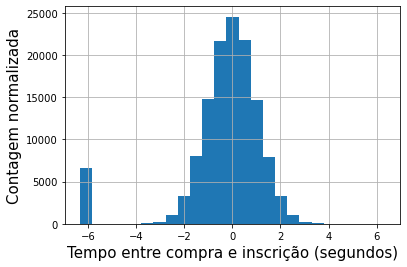

In [56]:
fraude_df_final["tempo"] = rescale_series(fraude_df_final.tempo)
fraude_df_final.tempo.hist(bins=25)
plt.xlabel("Tempo entre compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada",fontsize=15)

In [57]:
onehotencoded = [feature for feature in fraude_df_final.columns if "pais" not in feature and feature !="fraude"]

X = fraude_df_final[ [col for col in fraude_df_final.columns if col != "fraude"]]
Y = fraude_df_final["fraude"]

### Extraindo o dataframe final

In [58]:
fraude_df.to_csv("dados/Dados_fraude_modificados.csv", index=False)    

# **Engenharia de Recursos**

In [81]:
dados = pd.read_csv("dados/Dados_fraude_modificados.csv")

In [82]:
dados.head()

,id,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,fraude.1,id_por_dispositivo.1,id_por_ip,cadastro,compra,tempo,media_id
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,1.0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944,1.0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1,12.0
3,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461,1.0
4,159135,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,1,0,1,1,2015-05-21 06:03:03,2015-07-09 08:05:14,7331,1.0


In [83]:
# instanciando o onehotencoder para criar as variáveis dummies

ohe = OneHotEncoder(dtype=int)                       # instanciando
colunas_ohe = ohe.fit_transform(dados[['pais']])  
print(colunas_ohe.shape)

(129146, 181)


In [84]:
# convertendo a matriz esparsa em array 
colunas_ohe = colunas_ohe.toarray()

# criando dataframe com variaveis dummies
dados_ohe = pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names(['pais']))

In [85]:
dados_ohe.head(3)

,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,pais_Austria,pais_Azerbaijan,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [86]:
dados_ohe.shape

(129146, 181)

In [87]:
# criação do dataframe contendo as variáveis dummies + demais features 
# display(fraude_df.head())
dados_new = dados.drop(['pais'],axis=1)
fraude_dummies = pd.concat([dados_new,dados_ohe],axis=1)

# visualizando o dataframe criado
fraude_dummies.head()

,id,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,id_por_dispositivo,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,1,...,0,0,0,0,0,0,0,0,0,0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,1,...,1,0,0,0,0,0,0,0,0,0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,12,...,1,0,0,0,0,0,0,0,0,0
3,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,1,...,1,0,0,0,0,0,0,0,0,0
4,159135,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,1,...,0,0,0,0,0,0,0,0,0,0


# Treino e Teste

In [88]:
fraude_dummies.columns

Index(['id', 'valor', 'id_dispositivo', 'fonte', 'browser', 'genero', 'idade',
       'ip', 'fraude', 'id_por_dispositivo',
       ...
       'pais_United States', 'pais_Uruguay', 'pais_Uzbekistan', 'pais_Vanuatu',
       'pais_Venezuela', 'pais_Viet Nam', 'pais_Virgin Islands (U.S.)',
       'pais_Yemen', 'pais_Zambia', 'pais_Zimbabwe'],
      dtype='object', length=198)

In [89]:
type(fraude_dummies)

pandas.core.frame.DataFrame

In [90]:
fraude_dummies.dtypes

id                             int64
valor                          int64
id_dispositivo                object
fonte                         object
browser                       object
                               ...  
pais_Viet Nam                  int32
pais_Virgin Islands (U.S.)     int32
pais_Yemen                     int32
pais_Zambia                    int32
pais_Zimbabwe                  int32
Length: 198, dtype: object

In [91]:
# removendo as variáveis categóricas e que não influenciam na predição da variável target (fraude)

fraude_dummies = fraude_dummies.drop(['id','id_por_dispositivo','fonte','browser','genero','ip','cadastro','compra'],axis=1)

In [95]:
# removendo as variáveis categóricas e que não influenciam na predição da variável target (fraude)

fraude_dummies = fraude_dummies.drop(['id_por_ip','id_por_dispositivo.1','id_dispositivo','fraude.1','idade','valor'],axis=1)

In [96]:
X = fraude_dummies.drop(['fraude'],axis=1)
y = fraude_dummies['fraude']

In [97]:
X.index = range(len(X))
y.index = range(len(y))

In [98]:
X

,tempo,media_id,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,13882,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17944,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,12.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,41461,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,7331,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,5926,1.5,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
129142,77233,1.5,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
129143,67270,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129144,28816,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Algoritmo ExtraTreeClassifier

O Classificador de Árvores Extremamente Randomizadas (Extra Trees Classifier) é um tipo de técnica de aprendizado de conjunto que agrega os resultados de várias árvores de decisão descorrelacionadas coletadas em uma “floresta” para gerar o resultado da classificação. Em conceito, é muito semelhante a um Random Forest Classifier e só difere dele na forma de construção das árvores de decisão na floresta.

Para realizar a seleção de recursos usando o ExtraTreeClassifier, durante a construção da floresta, para cada recurso, a redução total normalizada nos critérios matemáticos usados na decisão de divisão de recursos (Índice de Gini se o Índice de Gini for usado na construção de a floresta) é calculado. Esse valor é chamado de Importância Gini do recurso. Para realizar a seleção de recursos, cada recurso é ordenado em ordem decrescente de acordo com a Importância Gini de cada recurso e o usuário seleciona os k principais recursos de acordo com sua escolha.

Em resumo o algoritmo irá nos auxiliar a selecionar atributos de acordo com "importancia" destes atributos.

In [99]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
_ = clf.fit(X,Y) #toda a base de dados

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

features [features.importancia > np.mean(features.importancia)].sort_values(by="importancia", ascending=False)

,feature,importancia
0,tempo,0.569744
1,media_id,0.420434


In [100]:
X_train, X_test, y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=23)

In [101]:
y_train.value_counts()

0    93506
1     9810
Name: fraude, dtype: int64

# Algoritmo Floresta Isolada

### Detecção de anomalias

Regularmente em vários problemas necessitamos saber quais pontos de um conjunto de dados apresentam comportamento diferente dos outros, como é o caso na detecção de fraudes. A floresta isolado (Isolated Forest) é uma tecnica muito interessante para detectar essas anomalias. Seu algoritmo é baseado em árvores de decisão aleatória e consiste basicamente em escolher aleatoriamente uma variável do conjunto de dados e executar uma cisão aleatória que tem como vantagem sobre outros algoritmos de detccção de anomalias suportar variáveis categóricas. O tamanho do caminho que um ponto tem são quanto passos são necessários para sair do nó inicial até o nó final.

Os pontos anômalos serão aqueles com caminho curto, pois estarão isolados, e os pontos “normais” terão um caminho mais longo, pois terão uma densidade maior, por exemplo imagine uma descrição do endereço de uma casa na Zona Oeste de São Paulo. “Pegue a primeira direita na Rua Clélia, depois contorne a esquerda em direção do Shopping Bourbon, etc…”. Existe bastante informação, pois a casa está em um lugar densamente habitado perto de outras casas. Agora imagine uma casa em uma ilha no litoral. “É a única casa naquela ilha”. Pois essa casa está isolada de outras. Similarmente pontos que podem ser descritos suscintamente podem ser classficados como outliers.

In [102]:
y_train = y_train.apply(lambda x: 1 if x==0 else -1)
y_test  = y_test.apply(lambda x: 1 if x==0 else -1)

In [103]:
fraude_dummies.columns

Index(['fraude', 'tempo', 'media_id', 'pais_Afghanistan', 'pais_Albania',
       'pais_Algeria', 'pais_Angola', 'pais_Antigua and Barbuda',
       'pais_Argentina', 'pais_Armenia',
       ...
       'pais_United States', 'pais_Uruguay', 'pais_Uzbekistan', 'pais_Vanuatu',
       'pais_Venezuela', 'pais_Viet Nam', 'pais_Virgin Islands (U.S.)',
       'pais_Yemen', 'pais_Zambia', 'pais_Zimbabwe'],
      dtype='object', length=184)

In [104]:
IF = IsolationForest(max_samples="auto",contamination = 0.095, random_state=1)

# validação cruzada
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF,
                   param_grid,
                   cv=2,
                   n_jobs=3,
                   scoring="f1",
                   verbose=10)

_ = clf.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


In [105]:
IF_best = clf.best_estimator_
y_predicted = IF_best.predict(X_test)
roc_auc = roc_auc_score(y_test,y_predicted)

In [106]:
print(classification_report(y_test,
                           y_predicted,
                           target_names=["anomalo","normal"]))
print("Área sob a curva ROC: {:0.3f}".format(roc_auc))

              precision    recall  f1-score   support

     anomalo       0.48      0.48      0.48      2458
      normal       0.94      0.95      0.95     23372

    accuracy                           0.90     25830
   macro avg       0.71      0.71      0.71     25830
weighted avg       0.90      0.90      0.90     25830

Área sob a curva ROC: 0.710


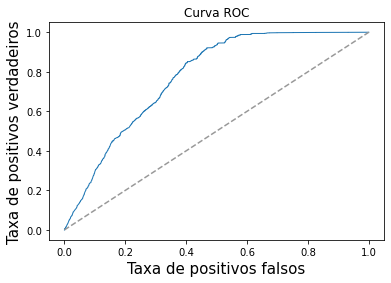

In [109]:
IF_probs = IF_best.decision_function(X_test)
fpr, tpr, thresold = roc_curve(y_test, IF_probs)

plt.plot(fpr, tpr, lw = 1)

plt.plot([0,1],[0,1], '--', color=(0.6, 0.6, 0.6), label="sorte")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("Taxa de positivos falsos", fontsize=15)
plt.ylabel("Taxa de positivos verdadeiros", fontsize=15)
plt.title("Curva ROC", fontsize=12)

plt.show()

# Removendo features 

In [110]:
X["fraude"] = y # retornando a variavel y para o dataframe, logo o novo dataframe será o X

# separando dataframes de anomalia(1) e normais(0)
X_anomalias = X[X['fraude'] == 1] 
X_normal = X[X['fraude'] == 0]

In [113]:
import random
# X treino e teste
train_idxs = random.sample(list(X_normal.index), int(0.7* X_normal.shape[0])) 
X_train = X_normal.loc[train_idxs] #contem o target + feature
X_testing = X_normal.drop(train_idxs) #removendo os indices que foram para o de treino
X_testing = pd.concat([X_testing, X_anomalias], axis=0) #reunindo o dataframe teste + anomalias(1)

In [114]:
# resetando o indice
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

In [115]:
# separando variavel target Y de features X
Y_testing = X_testing['fraude'] 
X_testing = X_testing[ [ col for col in X_testing.columns if col != 'fraude']]

# conjunto de teste e treino
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size = 0.7, random_state=23)

Y_cv = Y_cv.apply(lambda x: 1 if x==0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x ==0 else -1)

X_train = X_train[ [col for col in X_testing.columns if col !='fraude']]

In [117]:
X_train

,tempo,media_id,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,70365,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,79233,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43663,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50635,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,28296,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81809,67385,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81810,45418,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
81811,51039,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81812,83095,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [118]:
X_testing

,tempo,media_id,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,15808,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,6337,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,71756,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53390,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,52174,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47327,85335,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
47328,4079,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47329,79929,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
47330,4008,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [120]:
Y_cv

34405   -1
27996    1
4924     1
40292    1
16131    1
        ..
9704     1
11190    1
26569   -1
9256     1
41555   -1
Name: fraude, Length: 33132, dtype: int64

In [121]:
Y_eval

11686    1
34192    1
35834    1
4878     1
29284    1
        ..
32791    1
37467   -1
19971    1
37480    1
24733    1
Name: fraude, Length: 14200, dtype: int64

In [116]:
param_grid = {"nu": np.linspace(0.001, 0.01, 5), "gamma": [0.01, 0.03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"],param_grid["gamma"]))

# Algoritmo de OneClassSVM

Um tipo específico de problema de classificação binária com exemplos de treinamento de classe única é chamado One-Class Classification (OCC). . A classificação de uma classe é resolvida usando um algoritmo de aprendizado não supervisionado ou semi-supervisionado, como máquinas de vetores de suporte de uma classe (1-SVM), descrição de dados de vetores de suporte (SVDD) etc. Um dos exemplos populares de classificação de uma classe é Anamoly Detecção (AD), ou seja, detecção de outliers e detecção de novidades

One-Class SVM é uma técnica de aprendizado não supervisionado para aprender a capacidade de diferenciar as amostras de teste de uma determinada classe de outras classes. 1-SVM é um dos métodos mais convenientes para abordar declarações de problemas OCC, incluindo AD. 1-SVM trabalha com a ideia básica de minimizar a hiperesfera da única classe de exemplos em dados de treinamento e considera todas as outras amostras fora da hiperesfera como outliers ou fora da distribuição de dados de treinamento. A figura abaixo mostra a imagem que demonstra a hiperesfera formada por 1-SVM para aprender a capacidade de classificar dados de distribuição fora do treinamento com base na hiperesfera.

A expressão matemática para calcular uma hiperesfera com centro c e raio r é

<img src='imgs/img1.png'> </img>

A expressão acima tenta minimizar o raio de uma hiperesfera. No entanto, a formulação acima é muito restritiva para outliers, portanto, a formulação mais flexível para tolerar outliers até certo ponto é dada por
<img src='imgs/img2.png'> </img>

Aqui a função phi é a transformação de hiperesfera de x amostras. A figura abaixo mostra como a formulação de uma hiperesfera forma uma hiperesfera minimizando o raio r, centro c.

<img src='imgs/img3.png'> </img>

In [125]:
from sklearn.svm import OneClassSVM


def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):
    SEED = 23    
    f1_max = 0
    param_list = random.sample(param_list, n_sample)
    remaining_fits = n_sample
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu = nu, gamma=gamma)
        print('Fitando modelo...')
        OCSVM.fit(X_train)
        
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")
        
        if f1 > f1_max:
            f1_max = f1
            OCSVN_best = OCSVM
        
            remaining_fits -=1
        
    return f1_max, OCSVM
    
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...


              precision    recall  f1-score   support

    anormais       0.30      0.89      0.45      3649
     normais       0.88      0.27      0.42     10551

    accuracy                           0.43     14200
   macro avg       0.59      0.58      0.43     14200
weighted avg       0.73      0.43      0.43     14200

Área sob a curva ROC: 0.584


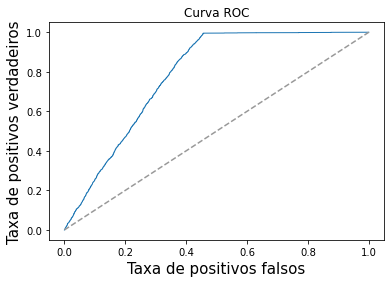

In [126]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval,Y_predicted)

print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anormais','normais']))
print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr,tpr, lw=1, label='ROC')
plt.plot([0,1],[0,1],'--', color=(0.6, 0.6, 0.6),label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros',fontsize=15)
plt.title('Curva ROC')

plt.show()